# **Medical cost prediction**

Dataset used: https://www.kaggle.com/datasets/mirichoi0218/insurance

In this project I will develop a machine learning model to predict the cost of medical insurance based on the following features:


*   **age**: age of primary beneficiary
*   **sex**: insurance contractor gender
*   **bmi**: Body mass index using the ratio of height to weight, ideally 18.5 to 24.9
*   **children**: Number of children covered by health insurance / Number of dependents
*   **smoker**: Smoking
*   **region**: the beneficiary's residential area in the US (northeast, southeast, southwest, northwest)

Let's import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import learning_curve, validation_curve, train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

from imblearn.pipeline import Pipeline as IMBPipeline


import missingno as msno

# Import Dataset

In [2]:
medical_data = pd.read_csv('insurance.csv')
medical_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Let's see the shape and general information of our dataset

In [3]:
medical_data.shape

(1338, 7)

In [4]:
medical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
medical_data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Let's now see if the dataset has missing values (Null values)

In [6]:
medical_data.isnull().sum(axis=0)

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

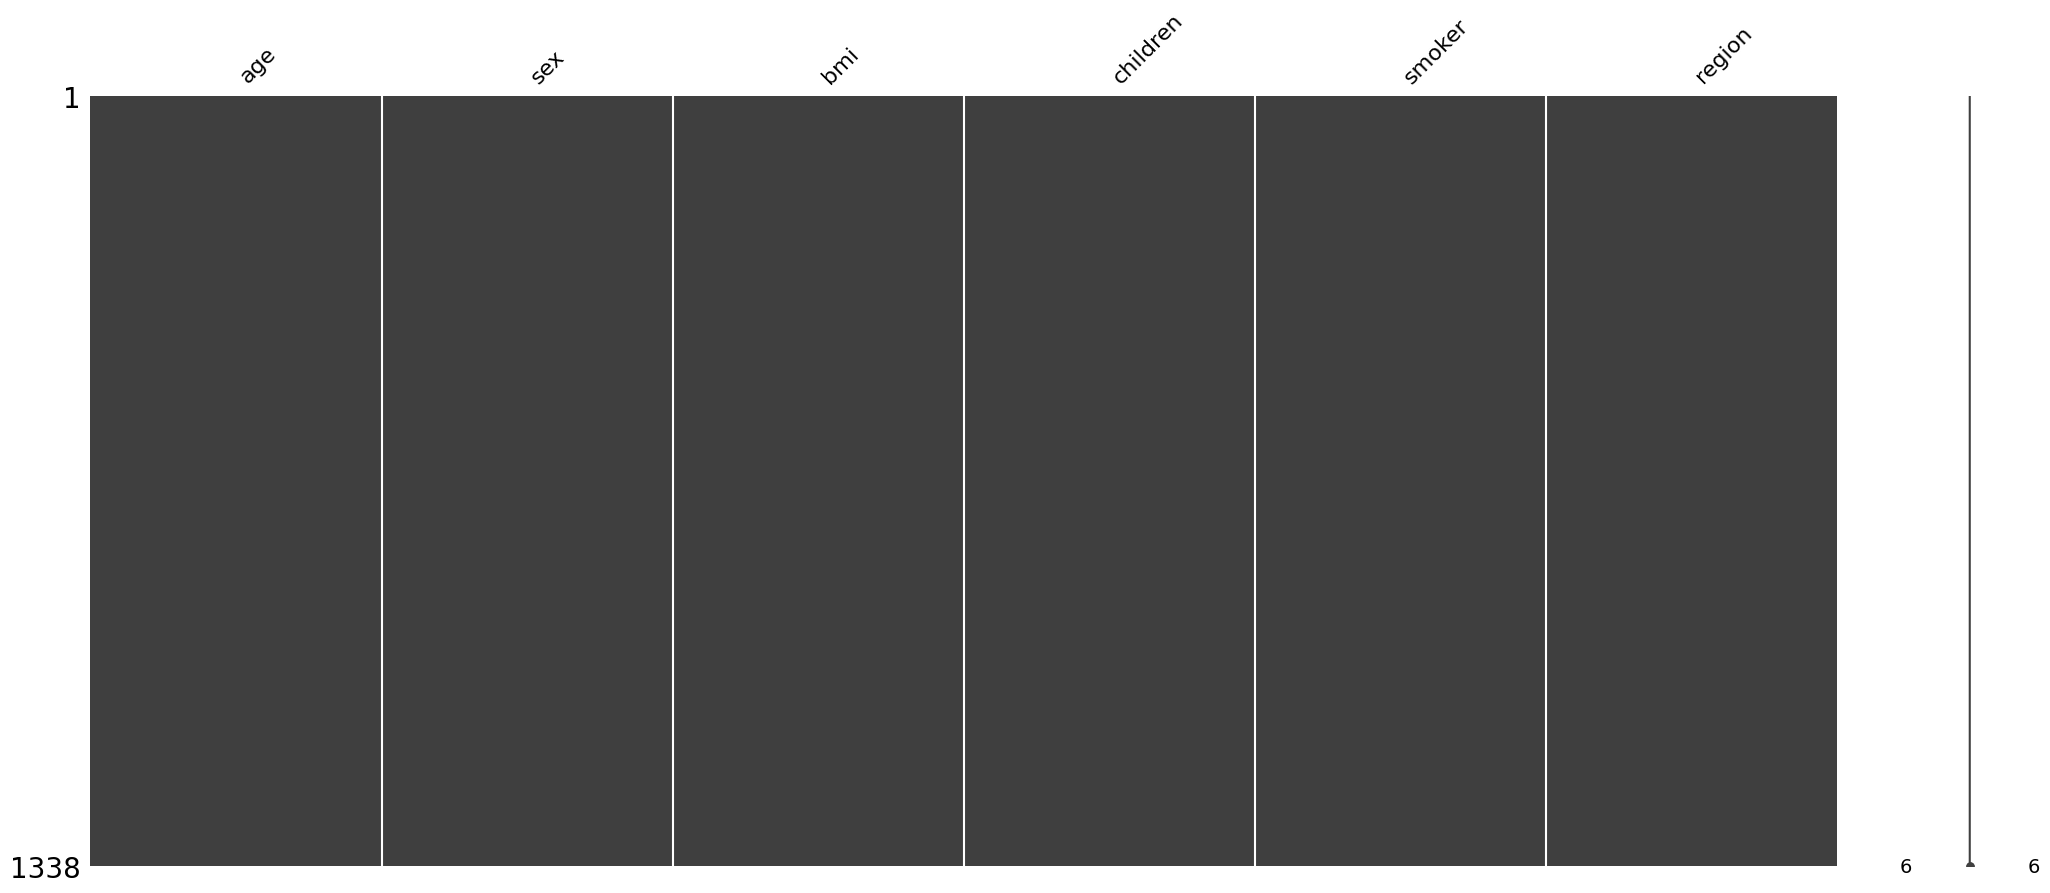

In [7]:
X = medical_data.iloc[:, :-1]
y = medical_data.iloc[:, -1]

msno.matrix(X);

The dataset is completely clean, with no missing data. This is very positive, but to make the project more similar to real case scenarios, we will introduce some noise (imputing missing values).
Before doing this, let's analyze grafically our features, this will give us important information helpful for data preprocessing and make us understand useful correlations between features, giving us a more wide view of the problem at hand.

# Data visualization


*Histogram of frequency distribution of age*

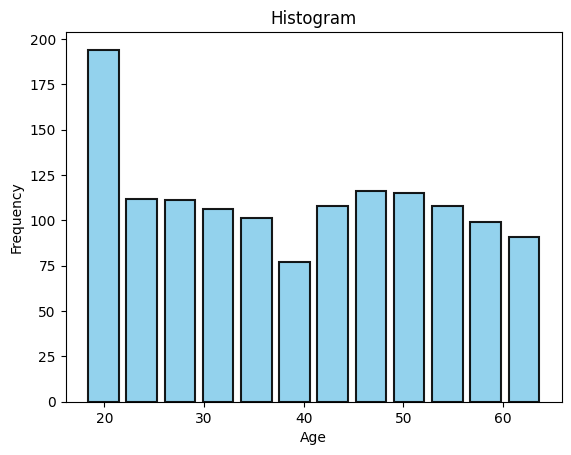

In [54]:
# Histogram
plt.hist(medical_data['age'],
         bins='auto',                       # Number of bins
         edgecolor='black',             # Color of edges
         linewidth=1.5,                 # Width of edge lines
         color='skyblue',               # Color of bars
         alpha=0.9,                     # Transparency of bars
         orientation='vertical',        # Orientation of the histogram ('horizontal' or 'vertical')
         rwidth=0.8,                    # Width of bars relative to bin width
         align='mid',                   # Alignment of bars with bin edges ('left', 'mid', 'right')
         )

plt.title('Histogram')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

*Density distribution of bmi*

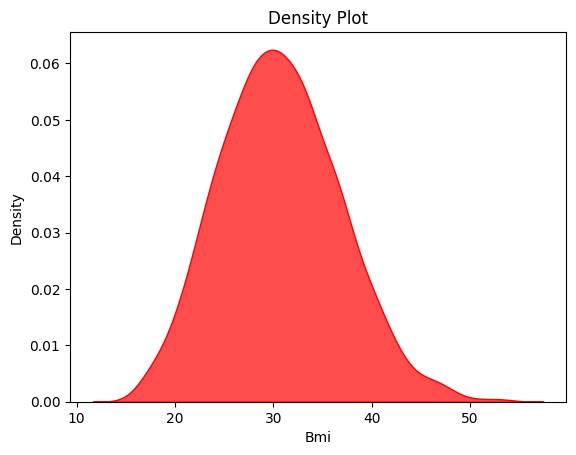

In [9]:
# Density Plot
sns.kdeplot(medical_data['bmi'],
            fill=True,        # Whether to shade the area under the curve
            color='red',        # Color of the line
            alpha=0.7,        # Transparency of the shading
           )
plt.title('Density Plot')
plt.xlabel('Bmi')
plt.ylabel('Density')
plt.show()

*Scatterplot of bmi values*

As we can see the values aren't well compact, we have some outliers, this could be something to take into account for the performance of our model.

In fact if the outliers aren't removed or normalized they could hinder performance and potentially cause **overfitting** (the model might become overly complex in an attempt to fit these outliers, resulting in overfitting where the model performs well on training data but poorly on unseen data) and also **reduced robustness** (models become less robust and less reliable when they are sensitive to extreme values)

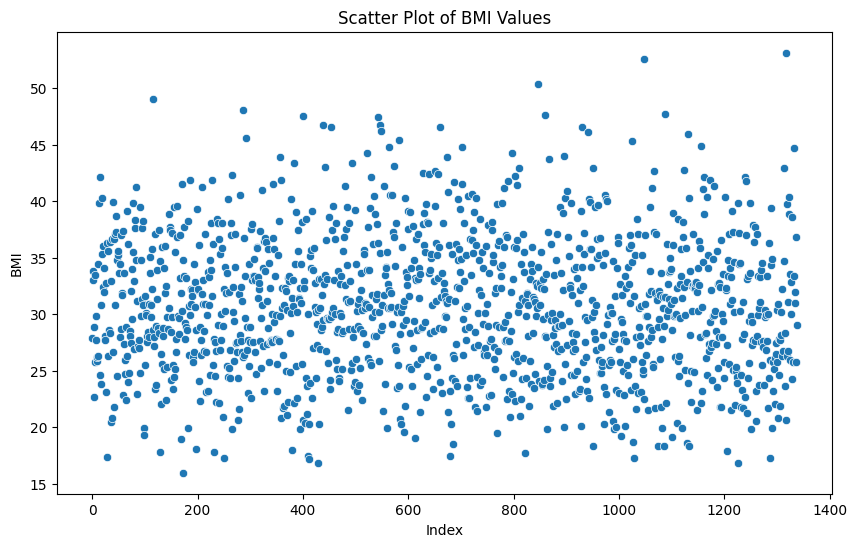

In [10]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=medical_data.index, y='bmi', data=medical_data)
plt.title('Scatter Plot of BMI Values')
plt.xlabel('Index')
plt.ylabel('BMI')
plt.show()

Further plot to underline existence of some outliers in the bmi feature:

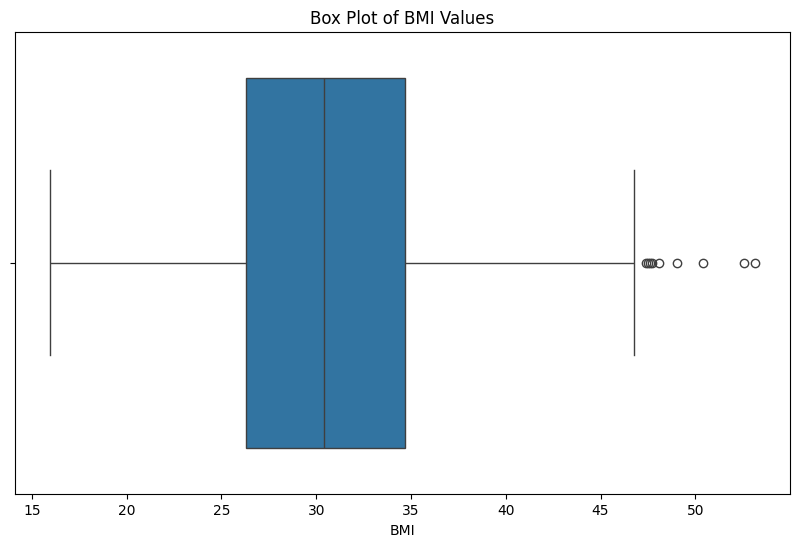

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=medical_data['bmi'])
plt.title('Box Plot of BMI Values')
plt.xlabel('BMI')
plt.show()

*Categorical values distribution*

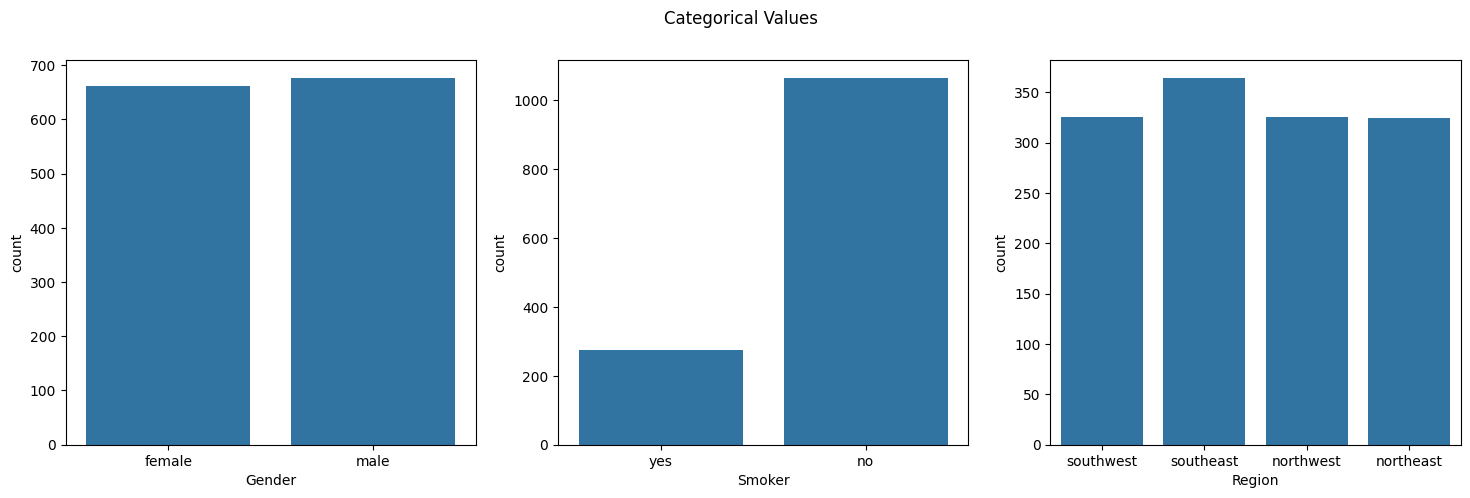

In [12]:

plt.figure(figsize=(18, 5))

# Subplot 1: Countplot for 'sex'
plt.subplot(1, 3, 1)
sns.countplot(x='sex', data=medical_data)
plt.xlabel('Gender')

# Subplot 2: Countplot for 'smoker'
plt.subplot(1, 3, 2)
sns.countplot(x='smoker', data=medical_data)
plt.xlabel('Smoker')

# Subplot 3: Countplot for 'region'
plt.subplot(1, 3, 3)
sns.countplot(x='region', data=medical_data)
plt.xlabel('Region')

plt.suptitle('Categorical Values')
plt.show()

It seems that they are all quite balanced exept for the smokers feature, the ratio of smokers to non-smokers is 1:4.

Imbalanced datasets can lead to several issues, including a **biased model** towards the majority class (non-smokers in this case) and may not perform well on the minority class (smokers). Also **poor generalization**: the model might not generalize well to unseen data, especially when predicting the minority class and **misleading performance metrics** like accuracy. For example, a model that predicts the majority class for all instances would still have a high accuracy but would perform poorly on the minority class.



Some methods to handle imbalanced data are resampling techniques (oversampling and undersampling) and using ensamble methods like Random Forest Regressor

*Distribution of charges with respect to age*


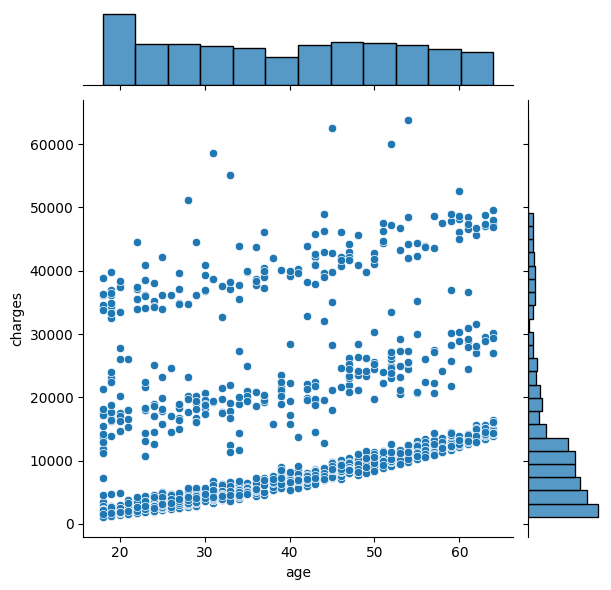

In [13]:
sns.jointplot(x='age', y='charges', data=medical_data, kind='scatter')
plt.show()

*Distribution of charges with respect to age with smoker feature*

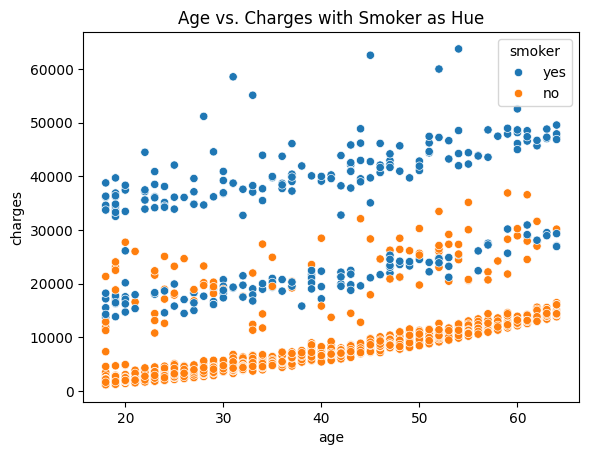

In [14]:
sns.scatterplot(x='age', y='charges', hue='smoker', data=medical_data) # 'hue' uses the 'smoker' variable to differentiate points by color.
plt.title('Age vs. Charges with Smoker as Hue')
plt.show()

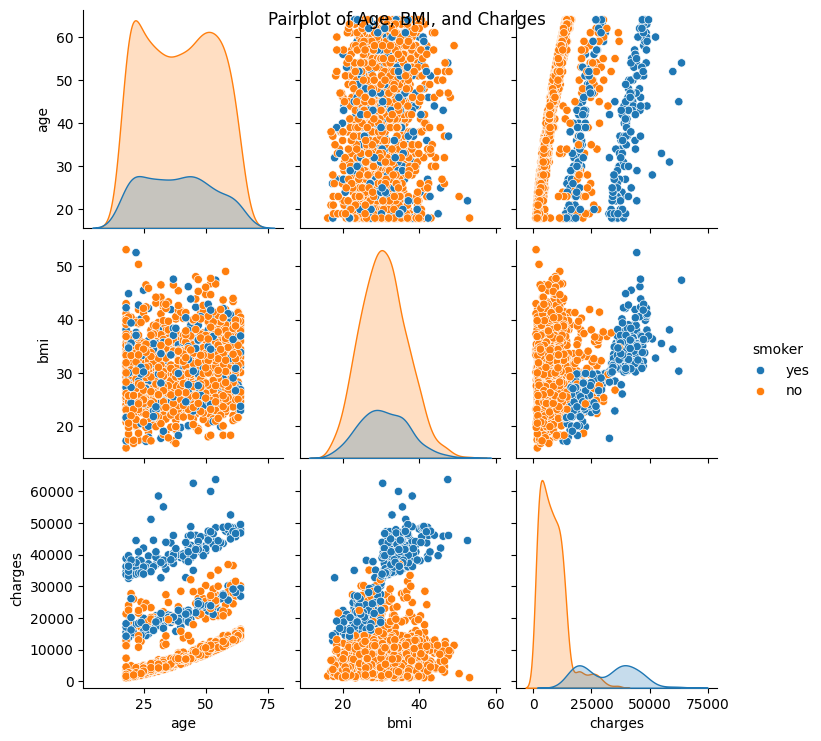

In [15]:
sns.pairplot(medical_data, vars=['age', 'bmi', 'charges'], hue='smoker')
plt.suptitle('Pairplot of Age, BMI, and Charges')
plt.show()

*Correlation Matrix*

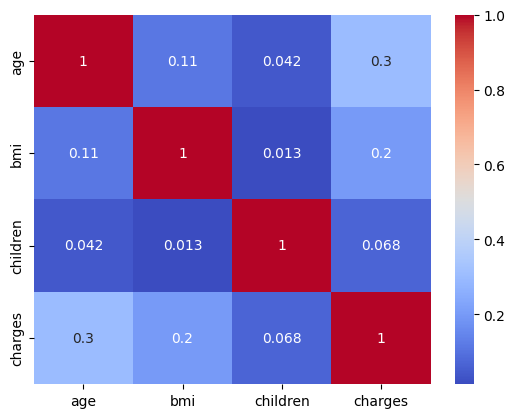

In [16]:
correlation_matrix = medical_data.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

- The moderate positive correlation between age and charges indicates that older individuals tend to have higher medical charges.
- There is a weak positive correlation between BMI and charges. As BMI increases, charges tend to increase slightly.
- There is a very weak positive correlation between the number of children and charges.

The low correlation values don't necessarily mean the features are unimportant. They might still be useful in a more complex, non-linear model or in combination with other features.

This should be kept into consideration if we want to take some actions such as feature engineering for creating interaction terms or polynomial features (typical non-linear relationships is suspected)

In cases like this its useful to use machine learning models capable of capturing non-linear relationships, such as Random Forests or Gradient Boosting Machines, all of which we will analyse into detail later in the project

# Missing values

Let's now make our dataset a bit noisy, it's important to understand how to handle missing values

In [17]:
#define add_missing function to create some noise

def add_missing(col, amount):
    X = col.copy()
    size = amount if amount >= 1 else int(len(X) * amount)
    indexes = np.random.choice(len(X), size, replace = False )
    X[indexes] = np.nan
    return X

In [18]:
noise_df = medical_data.copy() # avoid modifying the initial dataframe

#We are interested only in creating noise in the feature vectors, not in the label
for col in X:
  amount = np.random.uniform(0.0, 0.05)
  noise_df[col] = add_missing(noise_df[col], amount) # remove up to 5% of data from each column

print(noise_df.isnull().sum())

age         51
sex         10
bmi         34
children     3
smoker      16
region      48
charges      0
dtype: int64


<Axes: >

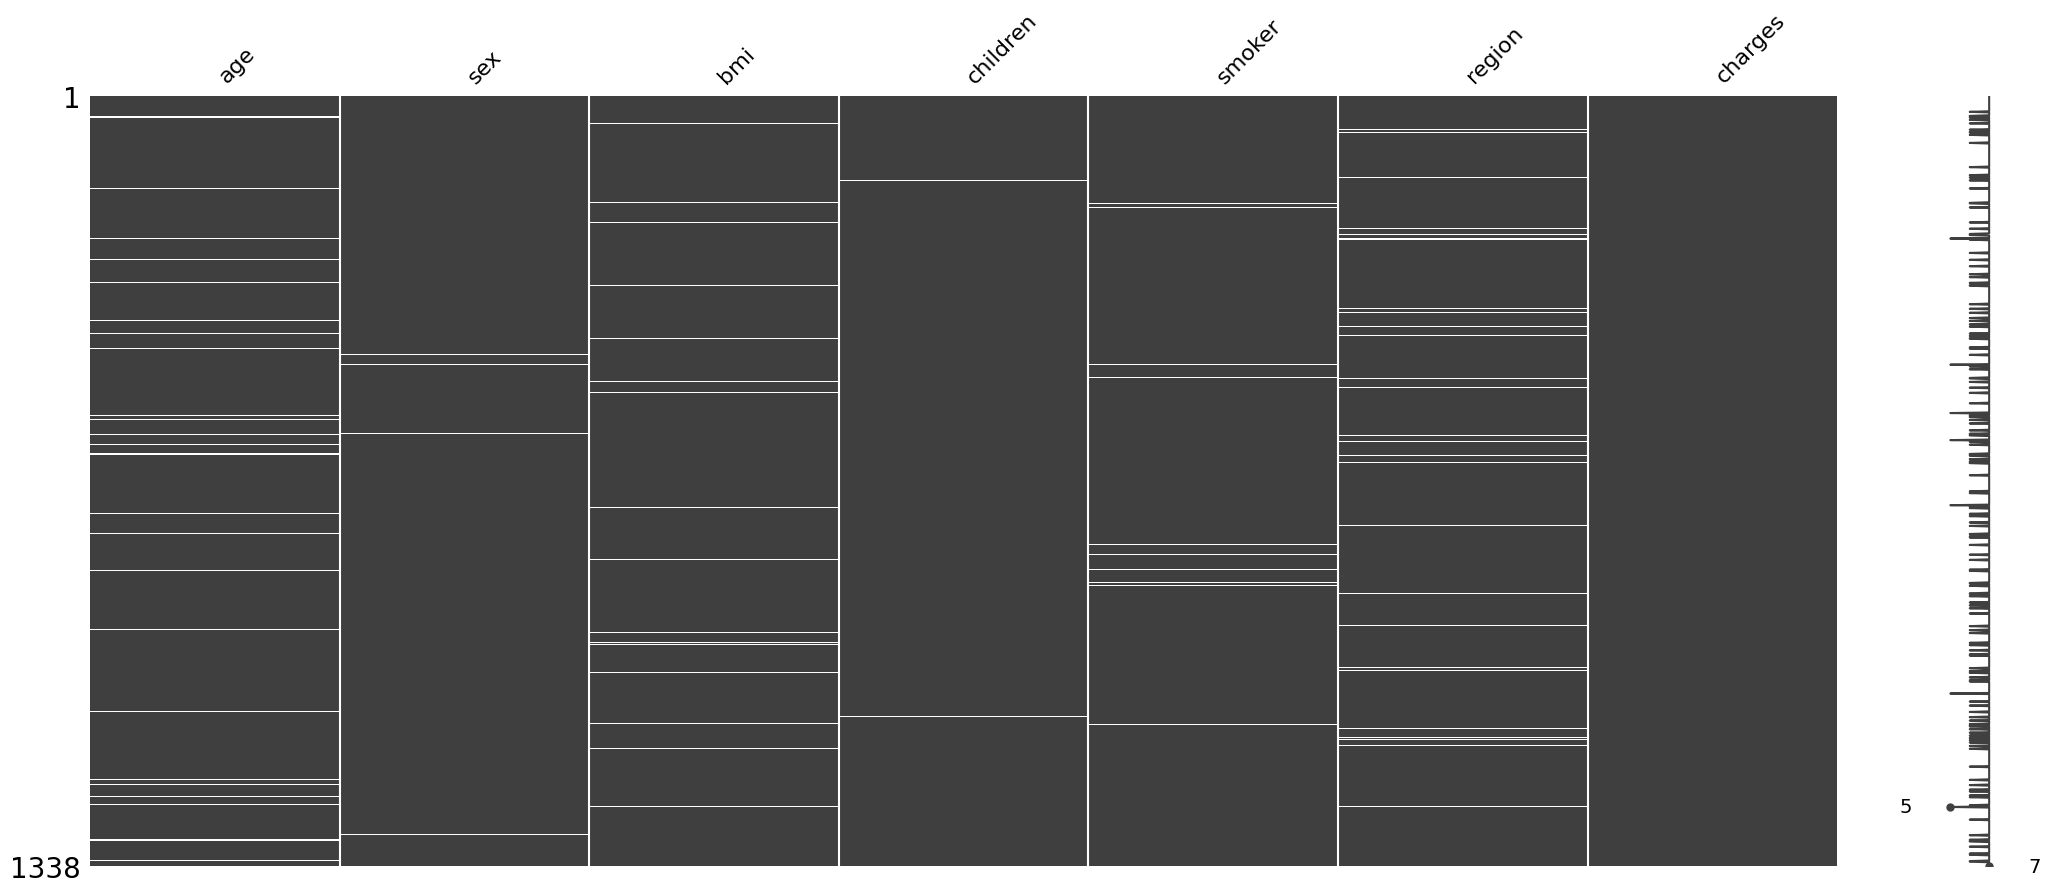

In [19]:
msno.matrix(noise_df)

In [20]:
X = noise_df.iloc[:, :-1]
y = noise_df['charges']

# Preprocessing Pipeline

Preprocessing is a very important step, to impute missing values and to standardize our data.
To make it clearer how I acted on data I drew a schematic overview of the actions to take:

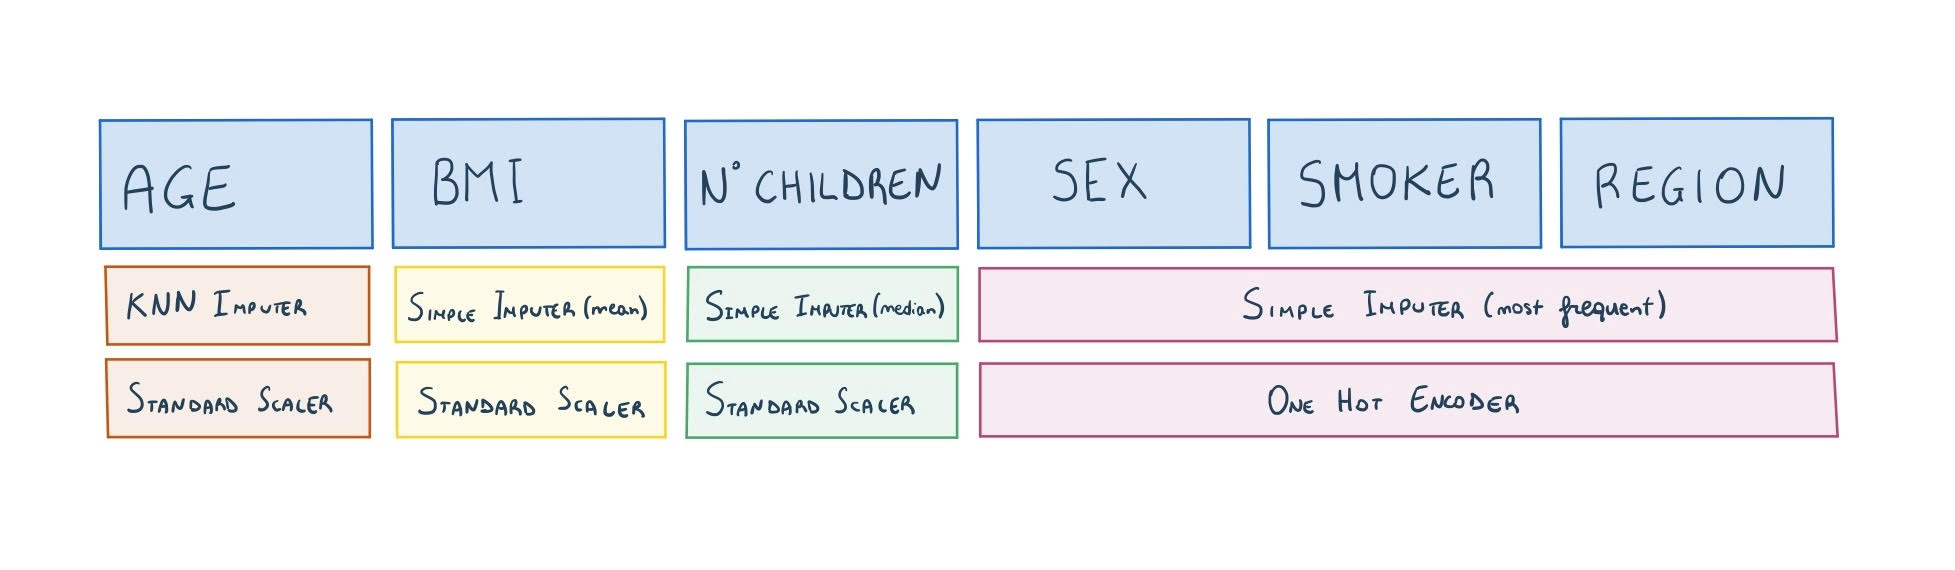

*Preprocessing pipeline*

In [21]:
pipeline_age = Pipeline([
    ('imp', KNNImputer(n_neighbors=5) ),
    ('scaler', StandardScaler() )
])

pipeline_bmi = Pipeline([
    ('imp', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler() )
])

pipeline_children = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler() )
])

pipeline_sex_smoker_region = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('hot', OneHotEncoder() )
])

final_transformation = ColumnTransformer(transformers=[
    ('age', pipeline_age ,['age'] ),
    ('bmi', pipeline_bmi, ['bmi'] ),
    ('children', pipeline_children, ['children']),
    ('sex_smoker_region', pipeline_sex_smoker_region, ['sex','smoker','region'] )
],
verbose_feature_names_out=False,
sparse_threshold=0
)

# Training and Test set

This is a regression task, so I won't stratify my data

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state=30)

# Model Selection

Let's proceed by defining a starting model or pipeline and for sanity check, lets run the fit method and the predict to verify if errors occur.

In [23]:
model_pipeline = IMBPipeline([
    ('trans', final_transformation),
    ('sampler', None),
    ('dim_reduction', PCA(n_components=0.8)),
    ('regressor', RandomForestRegressor())
])

# Train the regression pipeline
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('age',
                                                  Pipeline(steps=[('imp',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('bmi',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['bmi']),
                                                 ('children',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['children']),
                                                 ('sex_smoker_region',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('hot',
                                                                   OneHotEncoder())]),
                                                  ['sex', 'smoker', 'region'])],
                                   verbose_feature_names_out=False)),
                ('sampler', None), ('dim_reduction', PCA(n_components=0.8)),
                ('regressor', RandomForestRegressor())])

In [24]:
y_pred= model_pipeline.predict(X_test)
y_pred[:10]

array([41966.436658  ,  5759.1478944 ,  5658.2805445 , 15935.4603707 ,
       11624.9764208 ,  5341.2831597 ,  1956.09215908, 10781.3896762 ,
       40627.4937267 , 14879.5760083 ])

In [25]:
print("Mean Absolute Error:", mean_absolute_error(y_test,y_pred))
print("Mean Squared Error:", mean_squared_error(y_test,y_pred))
print("Root mean squared Error:", np.sqrt(mean_squared_error(y_test,y_pred)))
print("R2 score:" ,r2_score(y_test,y_pred))

Mean Absolute Error: 2969.5093729430982
Mean Squared Error: 26465381.495114084
Root mean squared Error: 5144.4515251982
R2 score: 0.828428777540283


It's time to define the configurations of the hyperparameters we use in the hyperparameter optimization phase of the model selection.

We have to test for different combinations of classification models, each with a different set of hyperparameters, different dimensionality reduction techniques, each with a different set of hyperparameters, and diffent methods to handle imbalanced classes. Here we skipped the sampler configurations for now and analysed dimensionality reduction and various Regressor models.

In [26]:
dim_reduction_configs = [
    {'dim_reduction': [None]},
    {'dim_reduction': [PCA()],
     'dim_reduction__n_components': [0.5, 0.7, 0.95]},
    {'dim_reduction': [SelectKBest(f_regression)],
     'dim_reduction__k': [5, 7, 10]}
]

classifier_configs = [
    {'regressor': [LinearRegression()]},
    {'regressor': [Ridge()],
     'regressor__alpha': [0.1, 1.0, 10.0]},
    {'regressor': [Lasso()],
     'regressor__alpha': [0.1, 1.0, 10.0]},
    {'regressor': [DecisionTreeRegressor()],
     'regressor__criterion': ['friedman_mse', 'squared_error', 'absolute_error'],
     'regressor__splitter': ['best', 'random'],
     'regressor__max_depth': [None, 5, 10, 30, 50],
     'regressor__min_samples_split': [2, 5, 10],
     'regressor__min_samples_leaf': [1, 2, 4]},
    {'regressor': [RandomForestRegressor()],
     'regressor__n_estimators': [10, 50, 100, 200],
     'regressor__max_depth': [None, 10, 20, 30]},
    {'regressor': [KNeighborsRegressor()],
     'regressor__n_neighbors': [3, 5, 7, 9],
     'regressor__weights': ['uniform', 'distance'],
     'regressor__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']},
    {'regressor': [SVR()]}
]


Now we can build a list of all possible configurations by putting all the elements together.

In [27]:
all_configs = []
for configuration in itertools.product(dim_reduction_configs,classifier_configs):
    # Merging of three dictionary into one
    all_parameters = []
    for element in configuration:
        for item in element.items():
            all_parameters.append(item)
    all_configs.append(dict(all_parameters)) # by dict(all_parameters) we create a dict from a list of pairs (key:value)

In [28]:
f'Number of all possible configurations: {len(all_configs)}'

'Number of all possible configurations: 21'

In [29]:
all_configs[:2]

[{'dim_reduction': [None], 'regressor': [LinearRegression()]},
 {'dim_reduction': [None],
  'regressor': [Ridge()],
  'regressor__alpha': [0.1, 1.0, 10.0]}]

In [30]:
rs = RandomizedSearchCV(model_pipeline,
    param_distributions=all_configs,
    n_iter=200,
    n_jobs=-1,
    cv = 2,
    scoring='neg_mean_squared_error'
)

In [31]:
scores = cross_validate(rs, X_train, y_train, scoring='r2', cv = 5, return_estimator=True)

In [32]:
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['regressor'],estimator.best_estimator_.get_params()['regressor'].get_params())
    print(scores['test_score'][index])
    print('-'*10)

None
RandomForestRegressor(max_depth=10) {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
0.8601600231257188
----------
SelectKBest(score_func=<function f_regression at 0x3510d51f0>)
DecisionTreeRegressor(criterion='friedman_mse', max_depth=5, min_samples_leaf=2,
                      splitter='random') {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'random'}
0.7709579453401897
----------
SelectKBest(k=5, score_func=<

In [33]:
for estimator in scores['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    r2_train = r2_score(y_train, pred_train)
    r2_test = r2_score(y_test, pred_test)
    print(f'r2 on training set:{r2_train}, r2 on test set:{r2_test}')

r2 on training set:0.9642587307982098, r2 on test set:0.8197162493515822
r2 on training set:0.7991534412362009, r2 on test set:0.792145964274505
r2 on training set:0.8118278953376914, r2 on test set:0.7970993672657638
r2 on training set:0.821640167299317, r2 on test set:0.8076533825800692
r2 on training set:0.8619294803051918, r2 on test set:0.8331499711374495


I tried running it several times and always found that:
- the best performing regressor on training data is always RandomForestRegressor(0.95 on training set on average), but it presents significant overfitting on test data (0.80 on average), this is a 0.15 difference in performance
- DecisionTreeRegressor performs worse on training data (0.83) but presents significant less overfitting on test data(0.82)

The other regressors never made it to the top five

Now i want to investigate RandomForestRegressor

In [34]:
randomForestRegressor_model_pipeline = IMBPipeline([
    ('trans', final_transformation),
    ('dim_reduction', PCA(n_components=0.8)),
    ('regressor', RandomForestRegressor())
])


dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [0.5, 0.7, 0.9]
    },
    {
        'dim_reduction': [SelectKBest(f_regression)],
        'dim_reduction__k': [5, 7, 10]
    }
]

forest_regressor_configs = [
    {
        'regressor': [RandomForestRegressor()],
        'regressor__n_estimators': [20,50,100,200],
        'regressor__max_depth': [10,20,30,50],
        'regressor__min_samples_leaf': [1,2,4]
    }
]

random_grid = []
for configuration in itertools.product(dim_reduction_configs,forest_regressor_configs):
    # Merging of two dictionary into one
    all_parameters = []
    for element in configuration:
        for item in element.items():
            all_parameters.append(item)
    random_grid.append(dict(all_parameters))

rs_best = RandomizedSearchCV(randomForestRegressor_model_pipeline,
    param_distributions=random_grid,
    n_iter=200,
    n_jobs=-1,
    cv = 2,
    scoring='neg_mean_squared_error'
)

best_scores = cross_validate(rs_best, X_train, y_train, scoring='r2', cv = 5, return_estimator=True, verbose=3, error_score='raise')


[CV] END ......................................., score=0.880 total time=   3.0s
[CV] END ......................................., score=0.825 total time=   3.1s
[CV] END ......................................., score=0.829 total time=   2.7s
[CV] END ......................................., score=0.784 total time=   3.0s
[CV] END ......................................., score=0.853 total time=   3.4s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.2s finished


In [35]:
for index, estimator in enumerate(best_scores['estimator']):
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['regressor'],estimator.best_estimator_.get_params()['regressor'].get_params())
    print(best_scores['test_score'][index])
    print('-'*10)

None
RandomForestRegressor(max_depth=20, min_samples_leaf=4) {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 20, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
0.8800938200273193
----------
SelectKBest(score_func=<function f_regression at 0x3510d51f0>)
RandomForestRegressor(max_depth=10, min_samples_leaf=4) {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': F

In [36]:
for estimator in best_scores['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    r2_train = r2_score(y_train, pred_train)
    r2_test = r2_score(y_test, pred_test)
    print(f'r2 on training set:{r2_train}, r2 on test set:{r2_test}')

r2 on training set:0.9063304416502462, r2 on test set:0.8400406727269062
r2 on training set:0.9045026832634738, r2 on test set:0.8396699640857397
r2 on training set:0.9038910347814715, r2 on test set:0.8382348202042567
r2 on training set:0.9042877809244667, r2 on test set:0.8416363057090601
r2 on training set:0.905568798029897, r2 on test set:0.8381214643868931


In [37]:
rfr_best_model = IMBPipeline([
    ('trans', final_transformation),
    ('regressor', RandomForestRegressor(n_estimators= 200, max_depth= 30, min_samples_leaf= 4))
])

rfr_best_model.fit(X_train, y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('age',
                                                  Pipeline(steps=[('imp',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('bmi',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['bmi']),
                                                 ('children',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['children']),
                                                 ('sex_smoker_region',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('hot',
                                                                   OneHotEncoder())]),
                                                  ['sex', 'smoker', 'region'])],
                                   verbose_feature_names_out=False)),
                ('regressor',
                 RandomForestRegressor(max_depth=30, min_samples_leaf=4,
                                       n_estimators=200))])

In [38]:
r2_score(y_test, rfr_best_model.predict(X_test))

0.8416196635977969

I would like now to further investigate the decision tree regressor model

In [39]:
decision_tree_regressor_model_pipeline = IMBPipeline([
    ('trans', final_transformation),
    ('dim_reduction', PCA(n_components=0.8)),
    ('regressor', DecisionTreeRegressor())
])

# Define configurations for dimensionality reduction and decision tree regressor
dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [0.5, 0.7, 0.9]
    },
    {
        'dim_reduction': [SelectKBest(f_regression)],
        'dim_reduction__k': [5, 7, 10]
    }
]

decision_tree_regressor_configs = [
    {
        'regressor': [DecisionTreeRegressor()],
        'regressor__criterion': ['poisson', 'friedman_mse', 'squared_error', 'absolute_error'],
        'regressor__splitter': ['best', 'random'],
        'regressor__max_depth': [None, 5, 10, 30, 50],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 4]
    }
]

# Create the random grid
random_grid = []
for configuration in itertools.product(dim_reduction_configs, decision_tree_regressor_configs):
    all_parameters = []
    for element in configuration:
        for item in element.items():
            all_parameters.append(item)
    random_grid.append(dict(all_parameters))

# Define and run RandomizedSearchCV
decisionTree_best = RandomizedSearchCV(decision_tree_regressor_model_pipeline,
                             param_distributions=random_grid,
                             n_iter=200,
                             n_jobs=-1,
                             cv=2,
                             scoring='neg_mean_squared_error')

decisionTree_scores = cross_validate(decisionTree_best, X_train, y_train, scoring='r2', cv=5, return_estimator=True, verbose=3, error_score='raise')

[CV] END ......................................., score=0.883 total time=   0.6s
[CV] END ......................................., score=0.814 total time=   0.6s
[CV] END ......................................., score=0.810 total time=   0.6s
[CV] END ......................................., score=0.752 total time=   0.6s
[CV] END ......................................., score=0.847 total time=   0.6s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.9s finished


In [40]:
for index, estimator in enumerate(decisionTree_scores['estimator']):
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['regressor'],estimator.best_estimator_.get_params()['regressor'].get_params())
    print(decisionTree_scores['test_score'][index])
    print('-'*10)

SelectKBest(k=7, score_func=<function f_regression at 0x3510d51f0>)
DecisionTreeRegressor(criterion='absolute_error', max_depth=5,
                      min_samples_leaf=2, min_samples_split=5) {'ccp_alpha': 0.0, 'criterion': 'absolute_error', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}
0.8826985795744253
----------
SelectKBest(k=7, score_func=<function f_regression at 0x3510d51f0>)
DecisionTreeRegressor(criterion='poisson', max_depth=5, min_samples_leaf=2,
                      min_samples_split=5) {'ccp_alpha': 0.0, 'criterion': 'poisson', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}
0.8138956576435102
---

In [41]:
for estimator in decisionTree_scores['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    r2_train = r2_score(y_train, pred_train)
    r2_test = r2_score(y_test, pred_test)
    print(f'r2 on training set:{r2_train}, r2 on test set:{r2_test}')

r2 on training set:0.8377205076088559, r2 on test set:0.8329876138708592
r2 on training set:0.8602751214314971, r2 on test set:0.8325966890797514
r2 on training set:0.8555440058028732, r2 on test set:0.8066713967661878
r2 on training set:0.8567762129119508, r2 on test set:0.807417834145839
r2 on training set:0.862149927591971, r2 on test set:0.8324754907187008


In [42]:
dtr_best_model = IMBPipeline([
    ('trans', final_transformation),
    ('regressor', DecisionTreeRegressor(criterion='squared_error', max_depth=5, min_samples_split=5, splitter='best'))
])

dtr_best_model.fit(X_train, y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('age',
                                                  Pipeline(steps=[('imp',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('bmi',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['bmi']),
                                                 ('children',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['children']),
                                                 ('sex_smoker_region',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('hot',
                                                                   OneHotEncoder())]),
                                                  ['sex', 'smoker', 'region'])],
                                   verbose_feature_names_out=False)),
                ('regressor',
                 DecisionTreeRegressor(max_depth=5, min_samples_split=5))])

In [43]:
r2_score(y_test, dtr_best_model.predict(X_test))

0.8034056663395454

The best result was 0.828 on test set with the last decision tree model, which gives significant less overfitting than the Random forest model.

learning curve to visualize the model's performance on the training and validation sets as the training size increases

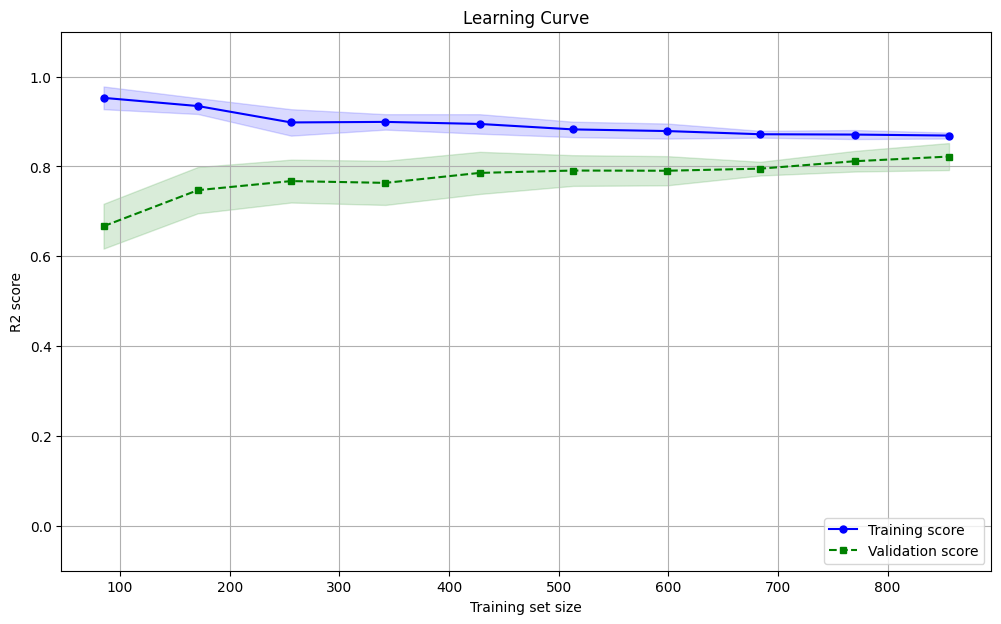

In [44]:
model = dtr_best_model

# Learning curve for the best estimator
train_sizes, train_scores, test_scores = learning_curve(
    model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    n_jobs=-1,
    scoring='r2',
    shuffle=True
)

# Calculate mean and standard deviation of training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plotting the learning curve
fig, ax = plt.subplots(figsize=(12, 7))

# Training score curve
ax.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training score')
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')

# Validation score curve
ax.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation score')
ax.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color='green')

# Customizing the plot
ax.set_xlabel('Training set size')
ax.set_ylabel('R2 score')  # Label for R2 score
ax.set_title('Learning Curve')
ax.legend(loc='lower right')
ax.grid()
ax.set_ylim([-0.1, 1.1])

plt.show()

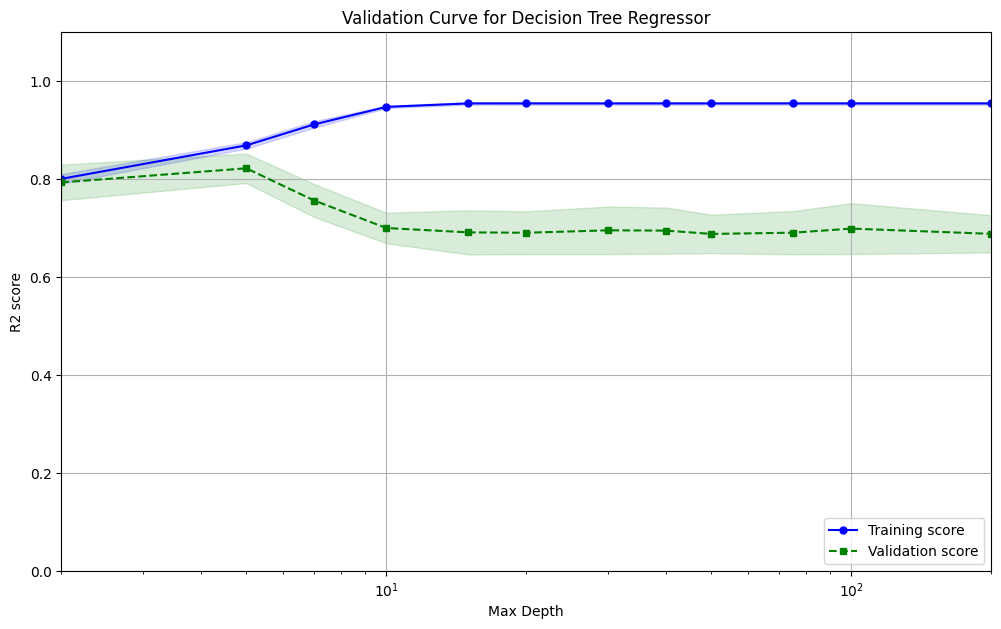

In [45]:
# Define the parameter range for 'n_estimators'
range_n_estimators = [2,5,7,10,15,20,30,40,50,75,100,200]


model = dtr_best_model

# Validation curve for 'n_estimators'
train_scores, test_scores = validation_curve(
    model,
    X=X_train,
    y=y_train,
    param_name='regressor__max_depth',
    param_range=range_n_estimators,
    cv=5,
    n_jobs=-1,
    scoring='r2'
)

# Calculate mean and standard deviation of training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plotting the validation curve
fig, ax = plt.subplots(figsize=(12, 7))

# Training score curve
ax.plot(range_n_estimators, train_mean, color='blue', marker='o', markersize=5, label='Training score')
ax.fill_between(range_n_estimators, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')

# Validation score curve
ax.plot(range_n_estimators, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation score')
ax.fill_between(range_n_estimators, test_mean - test_std, test_mean + test_std, alpha=0.15, color='green')

# Customizing the plot
ax.set_xlabel('Max Depth')
ax.set_ylabel('R2 score')
ax.set_title('Validation Curve for Decision Tree Regressor')
ax.legend(loc='lower right')
ax.grid()
ax.set_ylim([0.0, 1.1])
ax.set_xscale('log')
ax.set_xlim([min(range_n_estimators), max(range_n_estimators)])

plt.show()

In fact in our model we set max depth = 5, which is the moment in the graph were the two curves are overlapped. Further incrementing the max depth increases the training score but significantly decreases the validation score.

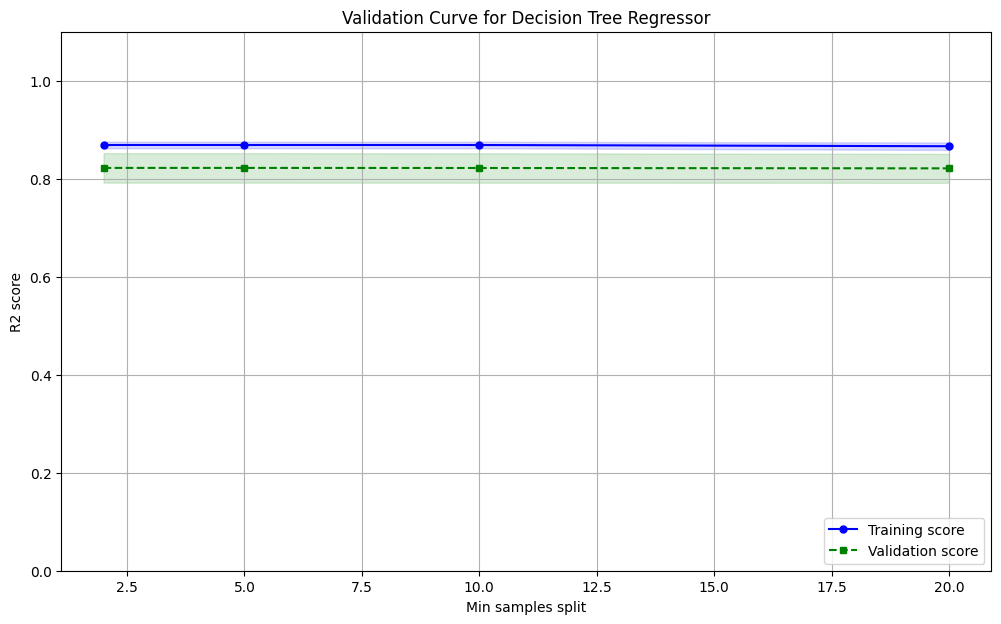

In [46]:
range_min_samples_split = [2, 5, 10, 20]

# Validation curve for 'min_samples_split'
train_scores, test_scores = validation_curve(
    model,
    X=X_train,
    y=y_train,
    param_name='regressor__min_samples_split',
    param_range=range_min_samples_split,
    cv=5,
    n_jobs=-1,
    scoring='r2'
)

# Calculate mean and standard deviation of training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plotting the validation curve
fig, ax = plt.subplots(figsize=(12, 7))

# Training score curve
ax.plot(range_min_samples_split, train_mean, color='blue', marker='o', markersize=5, label='Training score')
ax.fill_between(range_min_samples_split, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')

# Validation score curve
ax.plot(range_min_samples_split, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation score')
ax.fill_between(range_min_samples_split, test_mean - test_std, test_mean + test_std, alpha=0.15, color='green')

# Customizing the plot
ax.set_xlabel('Min samples split')
ax.set_ylabel('R2 score')
ax.set_title('Validation Curve for Decision Tree Regressor')
ax.legend(loc='lower right')
ax.grid()
ax.set_ylim([0.0, 1.1])


plt.show()

The best seems to be min_samples_split = 5

# Neural Model

Just to see potentially how much the score could improve I implemented a simple neural model

In [47]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='urllib3')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

/Users/sofiaformenti/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [48]:
X_transformed = final_transformation.fit_transform(X)

In [49]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(1, activation='linear')
])

# Compile
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='mean_squared_error', 
              metrics=['mae'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=30, min_lr=1e-7)

# Train
history = model.fit(X_train, y_train, 
                    epochs=10000, 
                    batch_size=32, 
                    validation_split=0.2,
                    callbacks=[early_stop, reduce_lr],
                    verbose=1)

# Predict
y_pred = model.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
print(f'R² Score: {r2:.4f}')
print(f'MAE: {mean_absolute_error(y_test, y_pred):.4f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}')

Epoch 1/10000


/Users/sofiaformenti/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 334355104.0000 - mae: 13645.4004 - val_loss: 310260032.0000 - val_mae: 12651.0928 - learning_rate: 0.0010
Epoch 2/10000
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 354362944.0000 - mae: 14013.5332 - val_loss: 309625728.0000 - val_mae: 12625.6035 - learning_rate: 0.0010
Epoch 3/10000
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 316269088.0000 - mae: 13319.9541 - val_loss: 306520512.0000 - val_mae: 12503.6182 - learning_rate: 0.0010
Epoch 4/10000
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 305533056.0000 - mae: 13059.3545 - val_loss: 295812576.0000 - val_mae: 12083.2363 - learning_rate: 0.0010
Epoch 5/10000
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 289320576.0000 - mae: 12401.7588 - val_loss: 269208896.0000 - val_mae: 10994.6367 - learning_rate: 0.0010
Epoch 6/10000
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 266434496.0000 - mae: 11390.1152 - val_loss: 221483536.0000 - val_mae: 9171.1152 - learning_rate: 0.0010
Epoch 7/10000

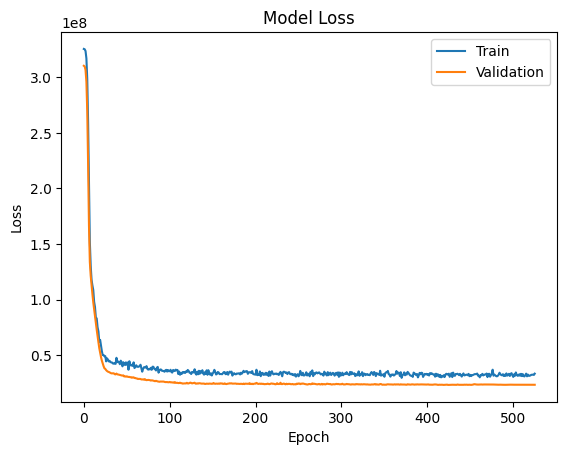

In [50]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Epoch 1/500


/Users/sofiaformenti/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 305439968.0000 - mae: 13056.5244 - val_loss: 310285024.0000 - val_mae: 12652.1719 - learning_rate: 0.0010
Epoch 2/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 312441888.0000 - mae: 13192.8770 - val_loss: 309756608.0000 - val_mae: 12631.2988 - learning_rate: 0.0010
Epoch 3/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 320156928.0000 - mae: 13501.2236 - val_loss: 307117152.0000 - val_mae: 12529.2070 - learning_rate: 0.0010
Epoch 4/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 335057984.0000 - mae: 13689.0420 - val_loss: 298113728.0000 - val_mae: 12179.9121 - learning_rate: 0.0010
Epoch 5/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 299838304.0000 - mae: 12589.6621 - val_loss: 275102656.0000 - val_mae: 11253.8682 - learning_rate: 0.0010
Epoch 6/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 242648224.0000 - mae: 10985.6904 - val_loss: 232318576.0000 - val_mae: 9521.7314 - learning_rate: 0.0010
Epoch 7/500
27/27 ━━━━━

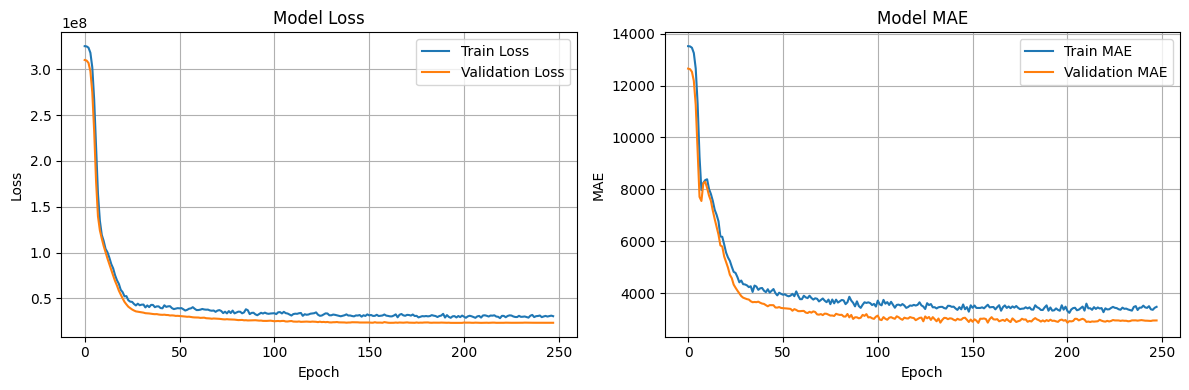

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
R² Score: 0.8490
MAE: 12050.8566
RMSE: 16983.8298


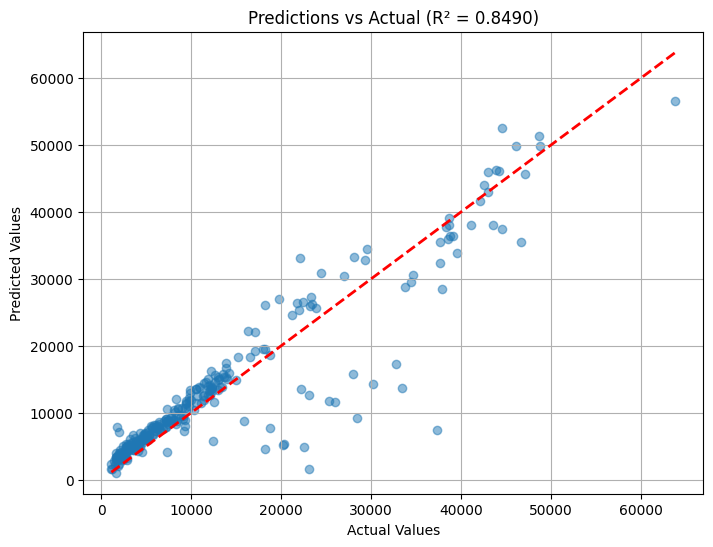

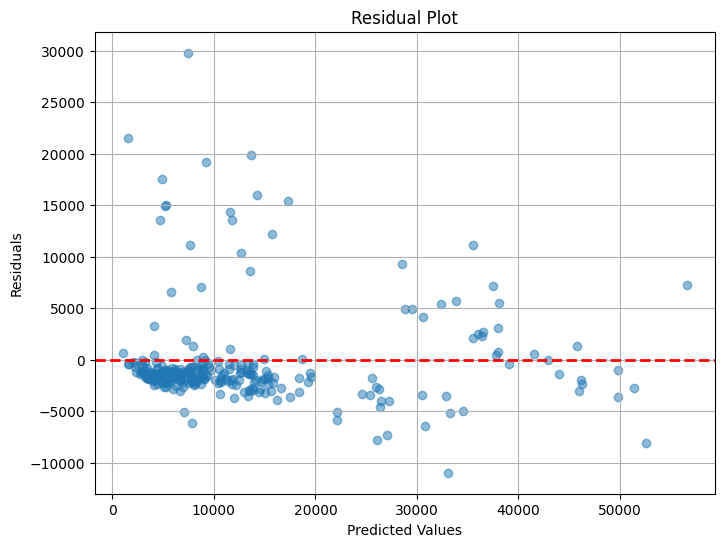

In [51]:
# Define the neural network model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Callbacks for better training
early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, min_lr=1e-7, verbose=1)

# Train with callbacks
history = model.fit(X_train, y_train, 
                    epochs=500,  # Increased max epochs, early stopping will handle it
                    batch_size=32, 
                    validation_split=0.2,
                    callbacks=[early_stop, reduce_lr],
                    verbose=1)

# Plot training & validation loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Predict on test set (use scaled data!)
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mae = np.mean(np.abs(y_test.values - y_pred))
rmse = np.sqrt(np.mean((y_test.values - y_pred)**2))

print(f'R² Score: {r2:.4f}')
print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')

# Scatter plot of predictions vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Predictions vs Actual (R² = {r2:.4f})')
plt.grid(True)
plt.show()

# Residual plot
residuals = y_test - y_pred.flatten()
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

there's a clear pattern: excellent predictions for lower values (0-15k) but increasing errors for higher values (30k-60k).
There are some common reasons for why this could happen:

Imbalanced data distribution

Scale differences (model is optimized for the majority at the expense of higher values)

Heteroscedasticity

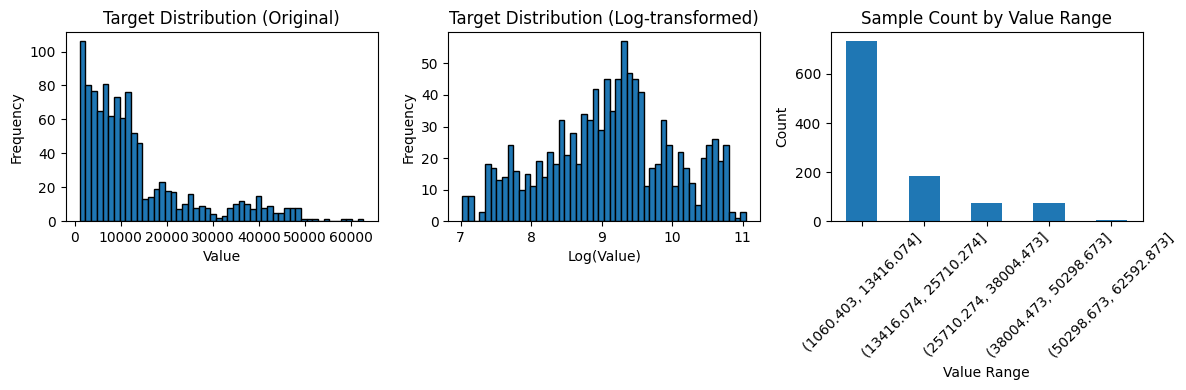

Sample counts by range:
charges
(1060.403, 13416.074]     733
(13416.074, 25710.274]    183
(25710.274, 38004.473]     74
(38004.473, 50298.673]     74
(50298.673, 62592.873]      6
Name: count, dtype: int64


In [52]:
# Visualize your target distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(y_train, bins=50, edgecolor='black')
plt.title('Target Distribution (Original)')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(np.log1p(y_train), bins=50, edgecolor='black')
plt.title('Target Distribution (Log-transformed)')
plt.xlabel('Log(Value)')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
value_ranges = pd.cut(y_train, bins=5)
value_ranges.value_counts().sort_index().plot(kind='bar')
plt.title('Sample Count by Value Range')
plt.xlabel('Value Range')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Check sample distribution
print("Sample counts by range:")
print(pd.cut(y_train, bins=5).value_counts().sort_index())

# Conclusion

The final model chosen for this task was decision tree regression,  which gave a score of 0.828. This model was chosen instead of random forest regressor as the latter was performing large overfitting on the data.
Some further improvements that could be made include:
- dealing with outliers
  - trimming/capping or winsorization
  - Z-score and IQR method
- experimenting with robust regression, that could also help for outlier treatment
- dealing with overfitting of random forest